In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Read Dataset

In [2]:
df = pd.read_csv('/home/skpark/git/pose-detection-keypoints-estimation-yolov8/yoga_pose_keypoint.csv')
df.head()

image_name  \
frame_125_timestamp_4190.jpg feetup 0.491685 0.351411 0.490083 0.359745 0.464460 0.364021 0.489767    0.360714   
frame_113_timestamp_3788.jpg feetup 0.458289 0.355637 0.456721 0.363213 0.427998 0.365057 0.458174    0.361159   
frame_119_timestamp_3989.jpg feetup 0.480223 0.362767 0.477585 0.372385 0.443532 0.375350 0.486636    0.370313   
                                    0.470616 0.359361 0.470598 0.367231 0.444987 0.373867 0.478852    0.371032   
frame_137_timestamp_4592.jpg feetup 0.456647 0.346669 0.456061 0.354982 0.431373 0.362189 0.455126    0.360919   

                                                                                                       label  \
frame_125_timestamp_4190.jpg feetup 0.491685 0.351411 0.490083 0.359745 0.464460 0.364021 0.489767  0.465468   
frame_113_timestamp_3788.jpg feetup 0.458289 0.355637 0.456721 0.363213 0.427998 0.365057 0.458174  0.430887   
frame_119_timestamp_3989.jpg feetup 0.480223 0.362767 0.477585 0.372385 0.443532 0.375350 0.486636  0.443273   
                                    0.470616 0.359361 0.470598 0.367231 0.444987 0.373867 0.478852  0.430204   
frame_137_timestamp_4592.jpg feetup 0.456647 0.346669 0.456061 0.354982 0.431373 0.362189 0.455126  0.412194   

                                                                                                      nose_x  \
frame_125_timestamp_4190.jpg feetup 0.491685 0.351411 0.490083 0.359745 0.464460 0.364021 0.489767  0.340270   
frame_113_timestamp_3788.jpg feetup 0.458289 0.355637 0.456721 0.363213 0.427998 0.365057 0.458174  0.339965   
frame_119_timestamp_3989.jpg feetup 0.480223 0.362767 0.477585 0.372385 0.443532 0.375350 0.486636  0.344715   
                                    0.470616 0.359361 0.470598 0.367231 0.444987 0.373867 0.478852  0.340872   
frame_137_timestamp_4592.jpg feetup 0.456647 0.346669 0.456061 0.354982 0.431373 0.362189 0.455126  0.330334   

                                                                                                      nose_y  \
frame_125_timestamp_4190.jpg feetup 0.491685 0.351411 0.490083 0.359745 0.464460 0.364021 0.489767  0.447144   
frame_113_timestamp_3788.jpg feetup 0.458289 0.355637 0.456721 0.363213 0.427998 0.365057 0.458174  0.410096   
frame_119_timestamp_3989.jpg feetup 0.480223 0.362767 0.477585 0.372385 0.443532 0.375350 0.486636  0.414581   
                                    0.470616 0.359361 0.470598 0.367231 0.444987 0.373867 0.478852  0.399038   
frame_137_timestamp_4592.jpg feetup 0.456647 0.346669 0.456061 0.354982 0.431373 0.362189 0.455126  0.376016   

                                                                                                    upper_jaw_x  \
frame_125_timestamp_4190.jpg feetup 0.491685 0.351411 0.490083 0.359745 0.464460 0.364021 0.489767     0.333384   
frame_113_timestamp_3788.jpg feetup 0.458289 0.355637 0.456721 0.363213 0.427998 0.365057 0.458174     0.328742   
frame_119_timestamp_3989.jpg feetup 0.480223 0.362767 0.477585 0.372385 0.443532 0.375350 0.486636     0.334041   
                                    0.470616 0.359361 0.470598 0.367231 0.444987 0.373867 0.478852     0.333304   
frame_137_timestamp_4592.jpg feetup 0.456647 0.346669 0.456061 0.354982 0.431373 0.362189 0.455126     0.326090   

                                                                                                    upper_jaw_y  \
frame_125_timestamp_4190.jpg feetup 0.491685 0.351411 0.490083 0.359745 0.464460 0.364021 0.489767     0.425237   
frame_113_timestamp_3788.jpg feetup 0.458289 0.355637 0.456721 0.363213 0.427998 0.365057 0.458174     0.387733   
frame_119_timestamp_3989.jpg feetup 0.480223 0.362767 0.477585 0.372385 0.443532 0.375350 0.486636     0.382992   
                                    0.470616 0.359361 0.470598 0.367231 0.444987 0.373867 0.478852     0.365581   
frame_137_timestamp_4592.jpg feetup 0.456647 0.346669 0.456061 0.354982 0.431373 0.362189 0.455126     0.356238   

              

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 73 entries, ('frame_125_timestamp_4190.jpg', 'feetup', 0.49168536, 0.35141072, 0.49008286, 0.35974535, 0.46445975, 0.3640212, 0.48976704) to ('frame_114_timestamp_3800.jpg', 'mounting', 0.35685274, 0.8349973, 0.3696009, 0.8438548, 0.35483506, 0.77945, 0.39297113)
Data columns (total 69 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   image_name                           73 non-null     float64
 1   label                                73 non-null     float64
 2   nose_x                               73 non-null     float64
 3   nose_y                               73 non-null     float64
 4   upper_jaw_x                          73 non-null     float64
 5   upper_jaw_y                          73 non-null     float64
 6   mouth_end_right_x                    73 non-null     float64
 7   mouth_end_right_y                    73 non-null     f

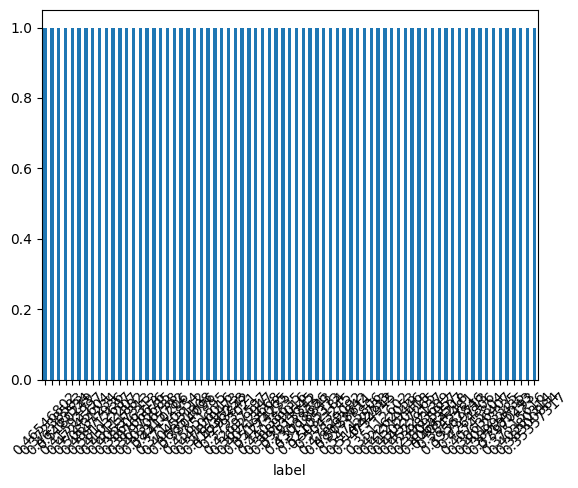

In [4]:
df.label.value_counts().plot(kind="bar")
plt.xticks(rotation=45)
plt.show()

## Train Test Split

In [5]:
# encoder label
encoder = LabelEncoder()
y_label = df['label']
y = encoder.fit_transform(y_label)
y

array([58, 49, 54, 48, 39, 43,  2, 42, 71, 67, 70, 65, 62, 60, 64, 63, 69,
       55,  0, 16, 29, 17, 31, 13, 28,  9, 24, 21, 35, 37, 44, 12, 27, 19,
       34, 10, 25, 11, 26, 18, 30,  7, 22, 20, 33, 50, 38, 72, 61, 66, 59,
       40, 68, 57, 52,  8, 32, 45, 23, 51, 46,  3, 36,  6, 15,  5, 47, 41,
       14, 53, 56,  1,  4])

In [6]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
class_weights

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.])

In [7]:
# Get keypoint dataset
X = df.iloc[:,12:]
X

right_earbase_x  \
frame_125_timestamp_4190.jpg feetup   0.491685 0.351411 0.490083 0.359745 0.464460 0.364021 0.489767         0.336796   
frame_113_timestamp_3788.jpg feetup   0.458289 0.355637 0.456721 0.363213 0.427998 0.365057 0.458174         0.336085   
frame_119_timestamp_3989.jpg feetup   0.480223 0.362767 0.477585 0.372385 0.443532 0.375350 0.486636         0.340317   
                                      0.470616 0.359361 0.470598 0.367231 0.444987 0.373867 0.478852         0.336890   
frame_137_timestamp_4592.jpg feetup   0.456647 0.346669 0.456061 0.354982 0.431373 0.362189 0.455126         0.326569   
...                                                                                                               ...   
frame_126_timestamp_4200.jpg mounting 0.381008 0.778518 0.398952 0.790202 0.387068 0.729456 0.405138         0.643117   
frame_150_timestamp_5000.jpg mounting 0.453353 0.586350 0.462671 0.596580 0.447166 0.554663 0.476976         0.467445   
                                      0.454712 0.541224 0.468595 0.550956 0.464186 0.518065 0.470538         0.436791   
frame_114_timestamp_3800.jpg mounting 0.338559 0.849987 0.355456 0.858046 0.340761 0.788771 0.359219         0.712135   
                                      0.356853 0.834997 0.369601 0.843855 0.354835 0.779450 0.392971         0.701365   

                                                                                                      right_earbase_y  \
frame_125_timestamp_4190.jpg feetup   0.491685 0.351411 0.490083 0.359745 0.464460 0.364021 0.489767         0.505081   
frame_113_timestamp_3788.jpg feetup   0.458289 0.355637 0.456721 0.363213 0.427998 0.365057 0.458174         0.472302   
frame_119_timestamp_3989.jpg feetup   0.480223 0.362767 0.477585 0.372385 0.443532 0.375350 0.486636         0.506510   
                                      0.470616 0.359361 0.470598 0.367231 0.444987 0.373867 0.478852         0.484088   
frame_137_timestamp_4592.jpg feetup   0.456647 0.346669 0.456061 0.354982 0.431373 0.362189 0.455126         0.441257   
...                                                                                                               ...   
frame_126_timestamp_4200.jpg mounting 0.381008 0.778518 0.398952 0.790202 0.387068 0.729456 0.405138         0.426373   
frame_150_timestamp_5000.jpg mounting 0.453353 0.586350 0.462671 0.596580 0.447166 0.554663 0.476976         0.496591   
                                      0.454712 0.541224 0.468595 0.550956 0.464186 0.518065 0.470538         0.489596   
frame_114_timestamp_3800.jpg mounting 0.338559 0.849987 0.355456 0.858046 0.340761 0.788771 0.359219         0.366303   
                                      0.356853 0.834997 0.369601 0.843855 0.354835 0.779450 0.392971         0.406551   

                                                                                                      right_earend_x  \
frame_125_timestamp_4190.jpg feetup   0.491685 0.351411 0.490083 0.359745 0.464460 0.364021 0.489767        0.327948   
frame_113_timestamp_3788.jpg feetup   0.458289 0.355637 0.456721 0.363213 0.427998 0.365057 0.458174        0.322825   
frame_119_timestamp_3989.jpg feetup   0.480223 0.362767 0.477585 0.372385 0.443532 0.375350 0.486636        0.326595   
                                      0.470616 0.359361 0.470598 0.367231 0.444987 0.373867 0.478852        0.326764   
frame_137_timestamp_4592.jpg feetup   0.456647 0.346669 0.456061 0.354982 0.431373 0.362189 0.455126        0.316998   
...                                                                                                              ...   
frame_126_timestamp_4200.jpg mounting 0.381008 0.778518 0.398952 0.790202 0.387068 0.729456 0.405138        0.549433   
frame_150_timestamp_5000.jpg mounting 0.453353 0.586350 0.462671 0.596580 0.447166 0.554663 0.476976        0.385323   
                                      0.454712 0.541224 0.468595 0.550956 0.464186 0.518065 0.470538        0.372599

In [8]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, shuffle=True, random_state=2022)

print("Number of Training keypoints: ", len(X_train))
print("Number of Testing keypoints: ", len(X_test))

ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

In [ ]:
scaler = MinMaxScaler()

In [ ]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_test

## Data Loader

In [ ]:
class DataKeypointClassification(Dataset):
    def __init__(self, X, y):
        self.x = torch.from_numpy(X.astype(np.float32))
        self.y = torch.from_numpy(y.astype(np.int64))
        self.n_samples = X.shape[0]
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
    def __len__(self):
        return self.n_samples

In [ ]:
train_dataset = DataKeypointClassification(X_train, y_train)
test_dataset = DataKeypointClassification(X_test, y_test)

In [ ]:
batch_size = 12
train_loader = DataLoader(train_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

## Model

In [ ]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        return out

In [ ]:
hidden_size = 256
model = NeuralNet(X_train.shape[1], hidden_size, len(class_weights))

In [ ]:
len(class_weights)

## Loss & Optimizer

In [ ]:
learning_rate = 0.01
criterion = nn.CrossEntropyLoss(weight=torch.from_numpy(class_weights.astype(np.float32)))
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## Training

In [ ]:
num_epoch = 40
for epoch in range(num_epoch):
    train_acc = 0
    train_loss = 0
    loop = tqdm(train_loader)
    for idx, (features, labels) in enumerate(loop):
        outputs = model(features)
        loss = criterion(outputs, labels)

        predictions = outputs.argmax(dim=1, keepdim=True).squeeze()
        correct = (predictions == labels).sum().item()
        accuracy = correct / batch_size
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loop.set_description(f"Epoch [{epoch}/{num_epoch}]")
        loop.set_postfix(loss=loss.item(), acc=accuracy)


## Test Model

In [ ]:
test_features = torch.from_numpy(X_test.astype(np.float32))
test_labels = y_test
with torch.no_grad():
    outputs = model(test_features)
    _, predictions = torch.max(outputs, 1)
predictions

In [ ]:
print(classification_report(test_labels, predictions, target_names=encoder.classes_))

In [ ]:
cm = confusion_matrix(test_labels, predictions)
df_cm = pd.DataFrame(
    cm, 
    index = encoder.classes_,
    columns = encoder.classes_
)
df_cm

In [ ]:
import seaborn as sns
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    plt.ylabel("Surface Ground Truth")
    plt.xlabel("Predicted Surface")
    plt.legend()
    
show_confusion_matrix(df_cm)

## save model


In [ ]:
PATH_SAVE = '/home/skpark/git/yolov8/models/pose_classification.pt'
torch.save(model.state_dict(), PATH_SAVE)

## Load Inference Model

In [ ]:
model_inference =  NeuralNet(
        X_train.shape[1], 
        hidden_size, 
        len(class_weights)
    )

model_inference.load_state_dict(
        torch.load(PATH_SAVE, map_location=device)
    )

In [ ]:
feature, label = test_dataset.__getitem__(51)

out = model_inference(feature)
_, predict = torch.max(out, -1)
print(f'\
    prediction label : {encoder.classes_[predict]} \n\
    ground thrut label : {encoder.classes_[label]}'
    )

In [ ]:
encoder.classes_